In [16]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import requests
import os
import warnings
from tqdm import tqdm
from typing import Dict, Optional, Tuple
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from shapely.geometry import Point, LineString
import matplotlib.gridspec as gridspec

In [23]:
import functions
import importlib
importlib.reload(functions)
from functions import predict_IPDL_trip, extract_r_block, parse_scalar_self_multiplications, apply_scalar_rules

## 1. Make Prediction

In [24]:
root = '/Users/ryan/Documents/01.Research Projects/18.NYC Congestion Pricing/'
choice_data_23 = pd.read_csv(root + '2.Joint mode and destination modeling/(1226) choice_dataset_v2.csv')
choice_data_23['(Intercept)'] = 1
choice_data_23['Segment'] = choice_data_23['Pop_group'] + '_' + choice_data_23['Trip_purpose'] + '_' + choice_data_23['Time_period']

Segment_lst = ['NotLowIncome_Commute_Peak','NotLowIncome_Commute_Overnight','NotLowIncome_Other_Peak','NotLowIncome_Other_Overnight',
               'LowIncome_Commute_Peak','LowIncome_Commute_Overnight','LowIncome_Other_Peak','LowIncome_Other_Overnight',
               'Senior_Commute_Peak','Senior_Commute_Overnight','Senior_Other_Peak','Senior_Other_Overnight',
               'Student_Commute_Peak','Student_Commute_Overnight','Student_Other_Peak','Student_Other_Overnight']

### One segment

In [25]:
segment_name = Segment_lst[10]
file_path = root + '2.Joint mode and destination modeling/Model Results 1226/IPDL_%s.xlsx'%segment_name
df = pd.read_excel(file_path, sheet_name="Coefficients")
attr_name = df["term"].tolist()
attr_name = [s.replace('log_s_s.county.','log_s_s(county)') for s in attr_name]
attr_name = [s.replace('log_s_s.mode.','log_s_s(mode)') for s in attr_name]
attr_name = [s.replace('County_36061.0','County_36061-0') for s in attr_name]
attr_name = [s.replace('County_36061.1','County_36061-1') for s in attr_name]
coeff = df['estimate'].values
market_constant_name = [x for x in attr_name if x[:6]=='factor']

piece = choice_data_23[choice_data_23['Segment']==segment_name]

In [26]:
piece[['log_s_s0_pred','share_0_shared','Trip_num_pred']] = predict_IPDL_trip(piece,attr_name,market_constant_name,segment_name,coeff,print_metrics=True).iloc[:,:-1]

Market share level
MAE: 0.3994
NMAE: -13.89%
----------------
Trip level
MAE: 29.5432
NMAE: 2.15%
----------------


### Full population

In [27]:
# initialize columns once (optional but recommended)
pred_cols = ['log_s_s0_pred', 'share_0_shared', 'Trip_num_pred']
for c in pred_cols:
    if c not in choice_data_23.columns:
        choice_data_23[c] = np.nan

for segment_name in Segment_lst:

    pop_group, trip_purpose, time_period = segment_name.split('_')

    # ---- load coefficients ----
    file_path = (
        root
        + f'2.Joint mode and destination modeling/Model Results 1226/'
          f'IPDL_{segment_name}.xlsx'
    )
    df = pd.read_excel(file_path, sheet_name="Coefficients")

    attr_name = df["term"].tolist()

    # string cleanups
    attr_name = [s.replace('log_s_s.county.', 'log_s_s(county)') for s in attr_name]
    attr_name = [s.replace('log_s_s.mode.', 'log_s_s(mode)') for s in attr_name]
    attr_name = [s.replace('County_36061.0', 'County_36061-0') for s in attr_name]
    attr_name = [s.replace('County_36061.1', 'County_36061-1') for s in attr_name]

    coeff = df['estimate'].values
    market_constant_name = [x for x in attr_name if x.startswith('factor')]

    # ---- build mask (DO NOT reset index) ----
    mask = (
        (choice_data_23['Pop_group'] == pop_group) &
        (choice_data_23['Trip_purpose'] == trip_purpose) &
        (choice_data_23['Time_period'] == time_period)
    )

    piece = choice_data_23.loc[mask]

    # ---- predict ----
    print(segment_name)
    preds = predict_IPDL_trip(
        piece,
        attr_name,
        market_constant_name,
        segment_name,
        coeff,
        print_metrics = True
    )

    # preds must be aligned row-wise with `piece`
    # ---- assign back safely ----
    choice_data_23.loc[mask, pred_cols] = preds.iloc[:,:-1].values

NotLowIncome_Commute_Peak
Market share level
MAE: 0.4567
NMAE: -17.73%
----------------
Trip level
MAE: 191.0727
NMAE: 4.21%
----------------
NotLowIncome_Commute_Overnight
Market share level
MAE: 0.3409
NMAE: -17.90%
----------------
Trip level
MAE: 21.4299
NMAE: 5.16%
----------------
NotLowIncome_Other_Peak
Market share level
MAE: 0.4882
NMAE: -16.04%
----------------
Trip level
MAE: 218.0120
NMAE: 3.85%
----------------
NotLowIncome_Other_Overnight
Market share level
MAE: 0.4036
NMAE: -14.49%
----------------
Trip level
MAE: 50.5938
NMAE: 4.61%
----------------
LowIncome_Commute_Peak
Market share level
MAE: 0.3746
NMAE: -15.58%
----------------
Trip level
MAE: 66.5970
NMAE: 4.51%
----------------
LowIncome_Commute_Overnight
Market share level
MAE: 0.2917
NMAE: -14.93%
----------------
Trip level
MAE: 8.8767
NMAE: 5.59%
----------------
LowIncome_Other_Peak
Market share level
MAE: 0.4151
NMAE: -15.20%
----------------
Trip level
MAE: 87.4333
NMAE: 4.32%
----------------
LowIncome_Ot

In [28]:
# Log-level performance metrics
piece = choice_data_23.copy()

RMSE = np.sqrt(np.mean((np.square(piece['log_s_s0_pred']-piece['log_s_s0']))))
MAE = (np.abs(piece['log_s_s0_pred']-piece['log_s_s0'])).mean()
NRMSE = RMSE/piece['log_s_s0'].mean()
NMAE = MAE/piece['log_s_s0'].mean()
print(f'Market share level')
print(f'RMSE: {RMSE:.4f}')
print(f'MAE: {MAE:.4f}')
print(f'NRMSE: {NRMSE*100:.2f}%')
print(f'NMAE: {NMAE*100:.2f}%')
print('-------------')
# Trip-level performance metrics
RMSE = np.sqrt(np.mean((np.square(piece['Trip_num_pred']-piece['Trip_num']))))
MAE = (np.abs(piece['Trip_num_pred']-piece['Trip_num'])).mean()
NRMSE = RMSE/piece['Trip_num'].mean()
NMAE = MAE/piece['Trip_num'].mean()
print(f'Trip level')
print(f'RMSE: {RMSE:.4f}')
print(f'MAE: {MAE:.4f}')
print(f'NRMSE: {NRMSE*100:.2f}%')
print(f'NMAE: {NMAE*100:.2f}%')

Market share level
RMSE: 0.6807
MAE: 0.3848
NRMSE: -27.55%
NMAE: -15.57%
-------------
Trip level
RMSE: 381.6055
MAE: 60.5017
NRMSE: 24.97%
NMAE: 3.96%


In [29]:
choice_data = choice_data_23.copy()
choice_data['origin_region'].unique()

array(['CTS', 'NJS', 'NYC', 'NYS', 'Manhattan', 'PAS'], dtype=object)

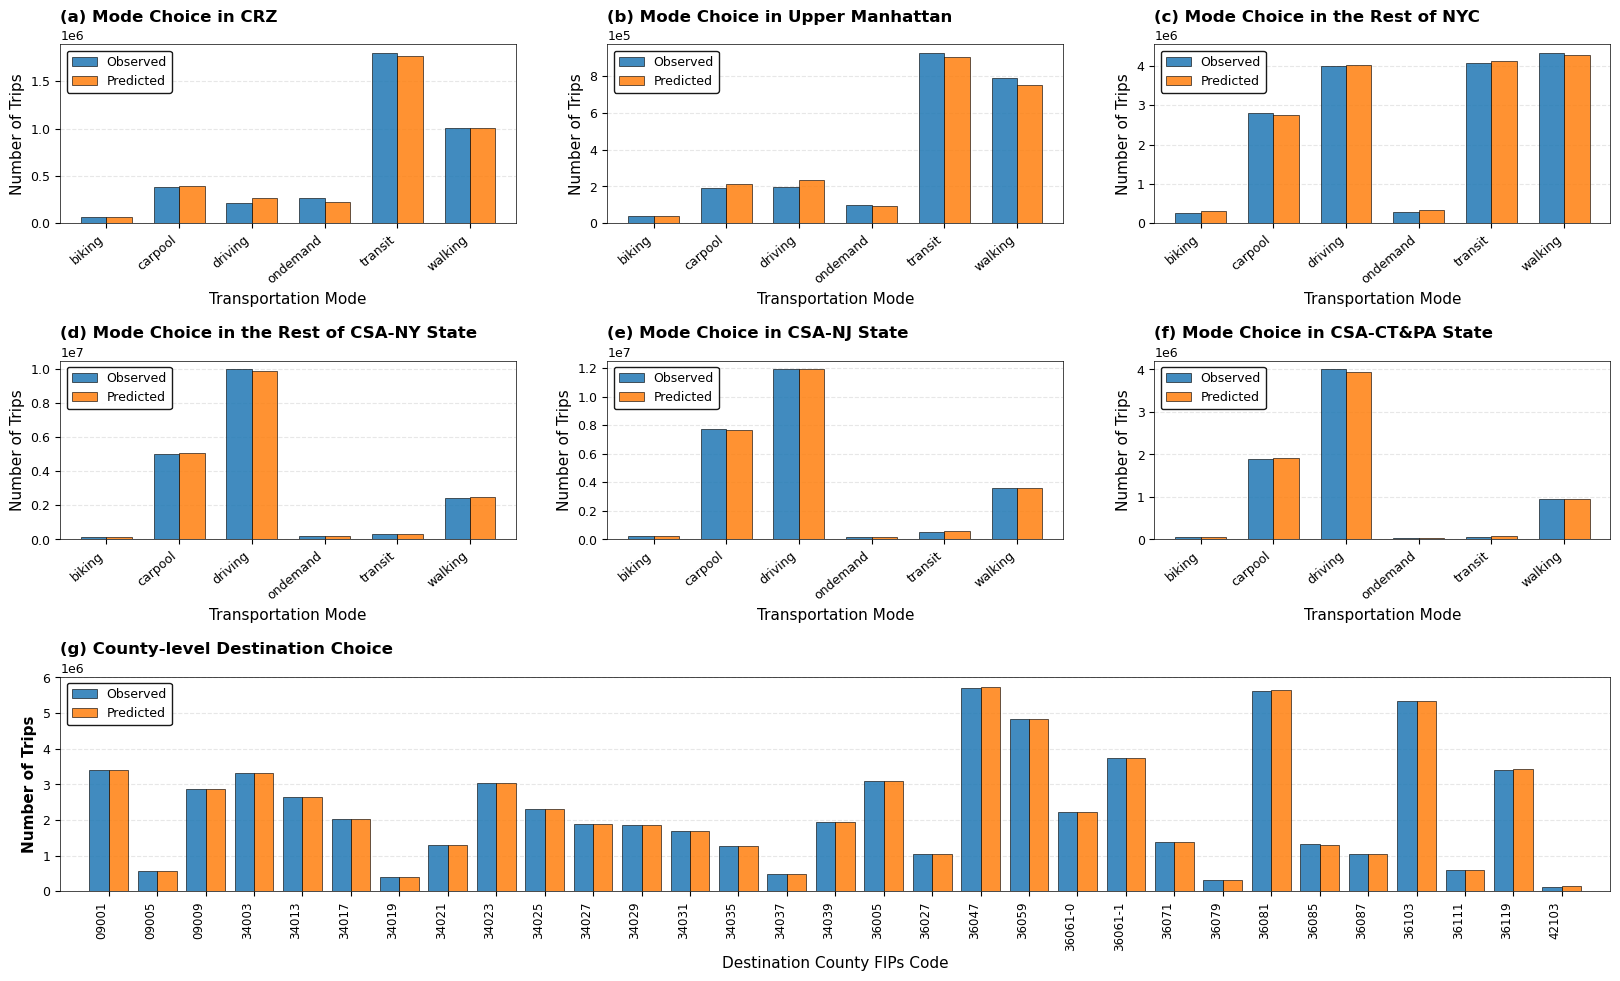

In [30]:
# Set publication-quality styling
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.titlesize'] = 14

# Define regions and their labels
regions = [
    ('36061-1', 'Mode Choice in CRZ'),
    ('36061-0', 'Mode Choice in Upper Manhattan'),
    (['NYC'], 'Mode Choice in the Rest of NYC'),
    (['NYS'], 'Mode Choice in the Rest of CSA-NY State'),
    (['NJS'], 'Mode Choice in CSA-NJ State'),
    (['CTS','PAS'], 'Mode Choice in CSA-CT&PA State')
]

# Create figure with GridSpec for custom layout
# Panel (g) is now taller with height ratio 1.2 instead of 0.75
fig = plt.figure(figsize=(20, 11))
gs = gridspec.GridSpec(3, 3, figure=fig, height_ratios=[1, 1, 1.2], 
                       hspace=0.72, wspace=0.2)

# Process each subplot for panels (a) through (f)
for idx, (region, label) in enumerate(regions):
    row = idx // 3
    col = idx % 3
    ax = fig.add_subplot(gs[row, col])
    
    # Filter data by region
    if region in ['36061-1','36061-0']:
        data = choice_data[choice_data['origin_county'] == region].copy()
    else:
        data = choice_data[choice_data['origin_region'].isin(region)].copy()
    
    # Calculate mode shares
    true_mode_share = data.groupby('mode')['Trip_num'].sum()
    pred_mode_share = data.groupby('mode')['Trip_num_pred'].sum()
    
    # Create comparison dataframe
    comparison = pd.DataFrame({
        'Observed': true_mode_share,
        'Predicted': pred_mode_share
    })
    
    # Plot grouped bar chart
    x = np.arange(len(comparison))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, comparison['Observed'], width, 
                   label='Observed', alpha=0.85, 
                   edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x + width/2, comparison['Predicted'], width, 
                   label='Predicted', alpha=0.85, 
                   edgecolor='black', linewidth=0.5)
    
    # Customize subplot
    ax.set_xlabel('Transportation Mode')
    ax.set_ylabel('Number of Trips')
    ax.set_title(f'({chr(97+idx)}) {label}', loc='left', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison.index, rotation=40, ha='right')
    
    # Add grid for easier reading
    ax.yaxis.grid(True, linestyle='--', alpha=0.3, zorder=0)
    ax.set_axisbelow(True)
    
    # Format y-axis with scientific notation if needed
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))

    ax.legend(loc='upper left', framealpha=0.9, edgecolor='black')
    
    # Add subtle border
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)

# Add panel (g) spanning the full width at the bottom
ax_g = fig.add_subplot(gs[2, :])  # Span all three columns in the third row

# Calculate destination choice data
True_mode_share = choice_data.groupby('destination_county')['Trip_num'].sum()
Pred_mode_share = choice_data.groupby('destination_county')['Trip_num_pred'].sum()

comparison_dest = pd.DataFrame({
    'Observed': True_mode_share,
    'Predicted': Pred_mode_share
})

# Plot grouped bar chart for destinations
x_dest = np.arange(len(comparison_dest))
width_dest = 0.4

bars1_dest = ax_g.bar(x_dest - width_dest/2, comparison_dest['Observed'], width_dest, 
                      label='Observed', alpha=0.85, 
                      edgecolor='black', linewidth=0.5)
bars2_dest = ax_g.bar(x_dest + width_dest/2, comparison_dest['Predicted'], width_dest, 
                      label='Predicted', alpha=0.85, 
                      edgecolor='black', linewidth=0.5)

# Customize panel (g)
ax_g.set_xlim([-1,31])
ax_g.set_xlabel('Destination County FIPs Code')
ax_g.set_ylabel('Number of Trips', fontweight='bold')
ax_g.set_title('(g) County-level Destination Choice', loc='left', fontweight='bold')
ax_g.set_xticks(x_dest)

# Adjust label rotation and size based on number of counties
ax_g.set_xticklabels(comparison_dest.index, rotation=90, ha='right', fontsize=8.5)


# Add grid
ax_g.yaxis.grid(True, linestyle='--', alpha=0.3, zorder=0)
ax_g.set_axisbelow(True)

# Format y-axis
ax_g.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))

# Add legend
ax_g.legend(loc='upper left', framealpha=0.9, edgecolor='black')

# Add subtle border
for spine in ax_g.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)

# # Save figure in multiple formats for academic papers
plt.savefig('/Users/ryan/Documents/01.Research Projects/18.NYC Congestion Pricing/6.TR-A Revision/Figures/Figure A3 (raw).jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)

## 2. Compare MNL, NL, and IPDl

In [33]:
file_path = root + '2.Joint mode and destination modeling/Model Results 1226/IPDL_full.xlsx'
df = pd.read_excel(file_path, sheet_name="Coefficients")
attr_name = df["term"].tolist()
attr_name = [s.replace('log_s_s.county.','log_s_s(county)') for s in attr_name]
attr_name = [s.replace('log_s_s.mode.','log_s_s(mode)') for s in attr_name]
attr_name = [s.replace('County_36061.0','County_36061-0') for s in attr_name]
attr_name = [s.replace('County_36061.1','County_36061-1') for s in attr_name]
coeff = df['estimate'].values
market_constant_name = [x for x in attr_name if x[:6]=='factor']

IPDL = choice_data_23[['origin_county','Pop_group','Trip_purpose','Time_period','destination_county',
                       'origin_region','destination_region','mode']].copy()
IPDL[['log_s_s0_pred','share_0_shared','Trip_num_pred']] = predict_IPDL_trip(choice_data_23,attr_name,market_constant_name,segment_name,coeff,print_metrics=True).iloc[:,:-1]

Market share level
MAE: 0.9252
NMAE: -37.44%
----------------
Trip level
MAE: 165.0651
NMAE: 10.80%
----------------


In [34]:
file_path = root + '2.Joint mode and destination modeling/Model Results 1226/NL_full.xlsx'
df = pd.read_excel(file_path, sheet_name="Coefficients")
attr_name = df["term"].tolist()
attr_name = [s.replace('log_s_s.county.','log_s_s(county)') for s in attr_name]
attr_name = [s.replace('log_s_s.mode.','log_s_s(mode)') for s in attr_name]
attr_name = [s.replace('County_36061.0','County_36061-0') for s in attr_name]
attr_name = [s.replace('County_36061.1','County_36061-1') for s in attr_name]
coeff = df['estimate'].values
market_constant_name = [x for x in attr_name if x[:6]=='factor']

NL = choice_data_23[['origin_county','Pop_group','Trip_purpose','Time_period','destination_county',
                       'origin_region','destination_region','mode']].copy()
NL[['log_s_s0_pred','share_0_shared','Trip_num_pred']] = predict_IPDL_trip(choice_data_23,attr_name,market_constant_name,segment_name,coeff,print_metrics=True).iloc[:,:-1]

Market share level
MAE: 8.4188
NMAE: -340.71%
----------------
Trip level
MAE: 499.2550
NMAE: 32.67%
----------------


In [35]:
file_path = root + '2.Joint mode and destination modeling/Model Results 1226/MNL_full.xlsx'
df = pd.read_excel(file_path, sheet_name="Coefficients")
attr_name = df["term"].tolist()
attr_name = [s.replace('log_s_s.county.','log_s_s(county)') for s in attr_name]
attr_name = [s.replace('log_s_s.mode.','log_s_s(mode)') for s in attr_name]
attr_name = [s.replace('County_36061.0','County_36061-0') for s in attr_name]
attr_name = [s.replace('County_36061.1','County_36061-1') for s in attr_name]
coeff = df['estimate'].values
market_constant_name = [x for x in attr_name if x[:6]=='factor']

MNL = choice_data_23[['origin_county','Pop_group','Trip_purpose','Time_period','destination_county',
                       'origin_region','destination_region','mode']].copy()
MNL[['log_s_s0_pred','share_0_shared','Trip_num_pred']] = predict_IPDL_trip(choice_data_23,attr_name,market_constant_name,segment_name,coeff,print_metrics=True).iloc[:,:-1]

Market share level
MAE: 4.7666
NMAE: -192.90%
----------------
Trip level
MAE: 1213.9595
NMAE: 79.45%
----------------
